# Classifying Emotions from Text

In [ ]:
!pip install -q evaluate
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.1
    Uninstalling transformers-4.53.1:
      Successfully uninstalled transformers-4.53.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import evaluate
from datasets import Dataset


import transformers
from transformers import EarlyStoppingCallback
import evaluate
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaPreTrainedModel, RobertaModel
from transformers import AutoTokenizer, BertForSequenceClassification, BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
from tqdm import tqdm

Pull Data

In [ ]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

df1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
df2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
df3 = pd.read_csv("data/full_dataset/goemotions_3.csv")
emotions = pd.concat([df1, df2, df3], ignore_index = True)
emotions.head()

--2025-07-12 22:53:18--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  --.-KB/s    in 0.1s    

2025-07-12 22:53:18 (91.1 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2025-07-12 22:53:18--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting respons

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


Dataset shape: (211225, 37)
Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_

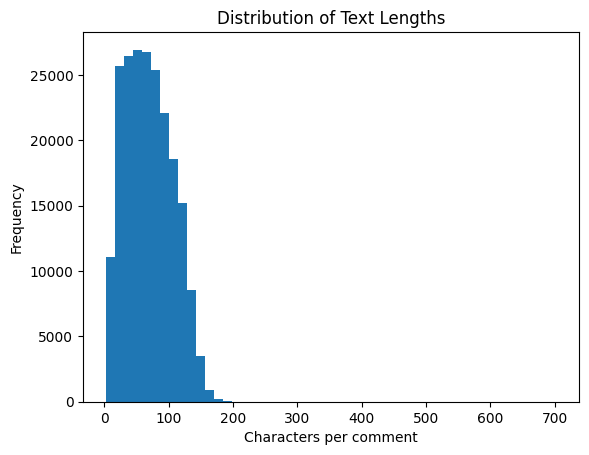

In [ ]:
# Check shape and columns
print(f"Dataset shape: {emotions.shape}")
print(emotions.columns)

# Inspect the first few rows
print(emotions.head())

# Check for missing values
print(emotions.isnull().sum())

# Distribution of text lengths (number of tokens or characters)
emotions['text_length'] = emotions['text'].apply(len)
plt.hist(emotions['text_length'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters per comment")
plt.ylabel("Frequency")
plt.show()

### Data Cleaning
* A text can have more than one row with only one flag for the list of emtion.   
* Making sure we have distinct rows of text where there can be more than one emotion flagged per row
* Removing rows that have no labels

In [ ]:
# Columns to drop
drop_cols = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id','example_very_unclear']

# Find columns that exist in the DataFrame
existing_cols_to_drop = [col for col in drop_cols if col in emotions.columns]

emotions.drop(existing_cols_to_drop, axis = 1, inplace = True)

# shape of data
print("SHAPE BEFORE MULTI-LABELS")
print("Shape of Emotions Dataset", emotions.shape)
print("Number of Unique Texts", emotions[['text','text_length']].nunique())

# Grouping by text and aggregated emtion flags
label_cols = emotions.columns.difference(['text','text_length'])
emotions_multi = emotions.groupby('text')[label_cols].max().reset_index()

print("\nSHAPE AFTER MULTI-LABELS")
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Number of Unique Texts", emotions_multi['text'].nunique())

SHAPE BEFORE MULTI-LABELS
Shape of Emotions Dataset (211225, 30)
Number of Unique Texts text           57732
text_length      192
dtype: int64

SHAPE AFTER MULTI-LABELS
Shape of Emotions Dataset (57732, 29)
Number of Unique Texts 57732


In [ ]:
emotions_multi.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,1,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Removing rows that have no labels
emotions_multi = emotions_multi[emotions_multi[label_cols].any(axis=1)]
print("Shape of Emotions Dataset", emotions_multi.shape)

Shape of Emotions Dataset (57730, 29)


### Spliting data into Train, Test, and Validation

* **60% - Train:** Used to train the model and update its weights   
* **20% - Validation:** Used to tune hyperparameters (like learning rate, batch size, epochs) and monitor for overfitting.
* **20% - Test:** Evaluate final model's performance on unseen data after all tuning is done

In [ ]:
# Creating relevant columns for labels
# Y value
label_cols = emotions.columns.difference(['text','text_length'])

# Splitting Train, Test, Validation
x_train, x_temp, y_train, y_temp = train_test_split(emotions_multi['text'], emotions_multi[label_cols], test_size = 0.4, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 42)

# Combine features and labels into one dataframe for each split
train_emotions = pd.concat([x_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_emotions   = pd.concat([x_val.reset_index(drop=True),   y_val.reset_index(drop=True)],   axis=1)
test_emotions  = pd.concat([x_test.reset_index(drop=True),  y_test.reset_index(drop=True)],  axis=1)

# Convert the DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_emotions)
val_dataset = Dataset.from_pandas(val_emotions)
test_dataset = Dataset.from_pandas(test_emotions)


## Exploratory Data Analysis

Continuing to use train dataset for data exploration

**Simran Exploration Takeaways:**
* There is some class imbalance when it comes to labels, many text are labeled as neutral. Which makes sense since many text can just be regular comments that don't always need to express emtions.
* Many text have 2 emotions labels

In [ ]:
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Shape of Train Dataset", x_train.shape, y_train.shape)
print("Shape of Test Dataset", x_test.shape, y_test.shape)
print("Shape of Validation Dataset", x_val.shape, y_val.shape)

Shape of Emotions Dataset (57732, 29)
Shape of Train Dataset (34639,) (34639, 28)
Shape of Test Dataset (11546,) (11546, 28)
Shape of Validation Dataset (11547,) (11547, 28)


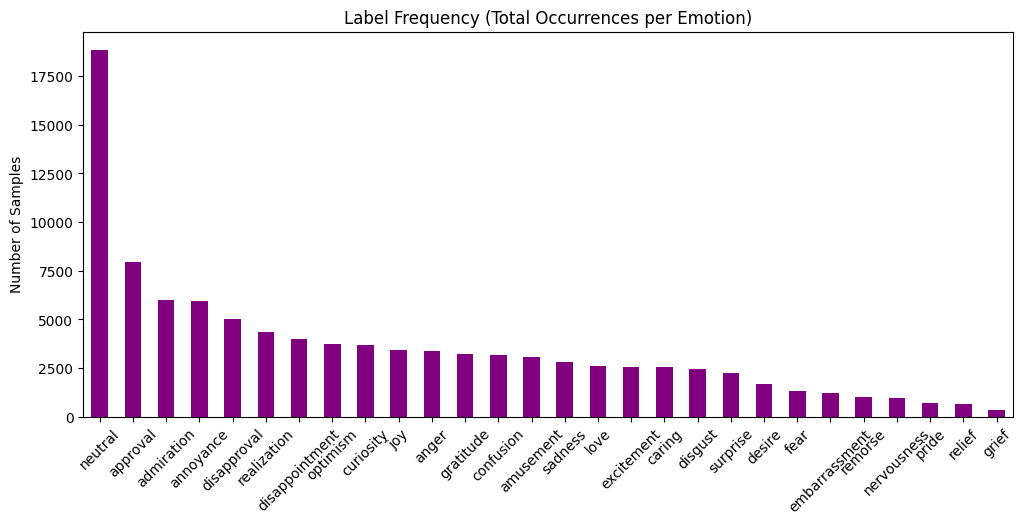

In [ ]:
# Exploring label frequency - seeing which emotions are more common across all text

label_counts = y_train.sum().sort_values(ascending=False)

plt.figure(figsize=(12,5))
label_counts.plot(kind='bar', color='purple')
plt.title("Label Frequency (Total Occurrences per Emotion)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

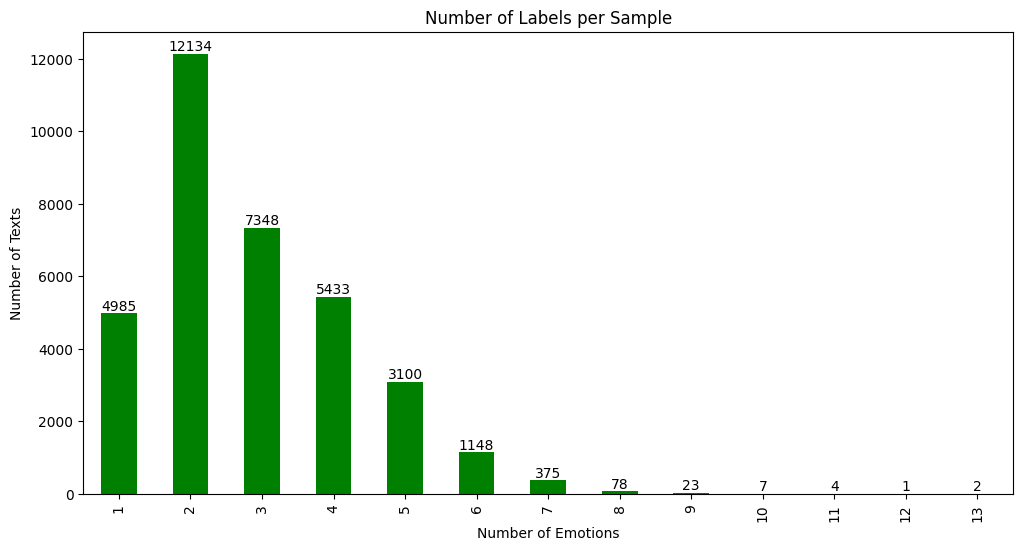

count    34638.000000
mean         2.858854
std          1.413529
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         13.000000
dtype: float64


In [ ]:
# Seeing number of labels a typical text has

num_labels_per_sample = y_train.sum(axis=1)
counts = num_labels_per_sample.value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='green')
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom', fontsize=10)
plt.title("Number of Labels per Sample")
plt.xlabel("Number of Emotions")
plt.ylabel("Number of Texts")
plt.show()

print(num_labels_per_sample.describe())


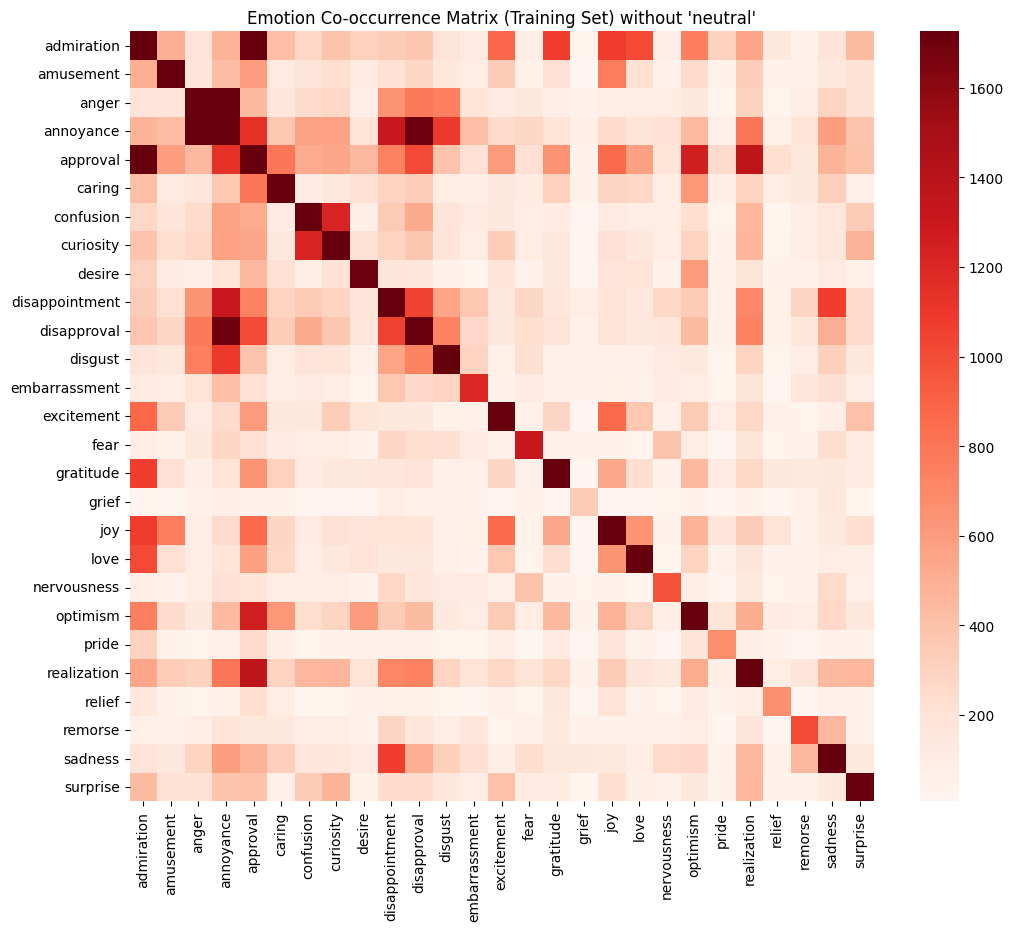

In [ ]:
# emotion co-occurence heatmap, remove "neutral" so it won't dominate the colors

import seaborn as sns

emotions_wo_neutral = y_train.columns.difference(['neutral'])
emotion_cooccur = y_train[emotions_wo_neutral].T.dot(y_train[emotions_wo_neutral])

plt.figure(figsize=(12, 10))
sns.heatmap(emotion_cooccur, cmap="Reds", xticklabels=True, yticklabels=True, vmax=emotion_cooccur.quantile(0.95).max())
plt.title("Emotion Co-occurrence Matrix (Training Set) without 'neutral'")
plt.show()


In [ ]:
# find top co-occurring pairs (excluding neutral)
top_pairs = emotion_cooccur.where(np.triu(np.ones(emotion_cooccur.shape), k=1).astype(bool))
top_pairs = top_pairs.stack().sort_values(ascending=False).reset_index().rename(columns ={'level_0':'emotion_1', 'level_1':'emotion_2',0:'co-orurrence'})

print(top_pairs.head(10))

    emotion_1       emotion_2  co-orurrence
0  admiration        approval        1785.0
1       anger       annoyance        1738.0
2   annoyance     disapproval        1698.0
3    approval     realization        1364.0
4   annoyance  disappointment        1307.0
5    approval        optimism        1260.0
6   confusion       curiosity        1224.0
7   annoyance        approval        1143.0
8   annoyance         disgust        1091.0
9  admiration             joy        1076.0


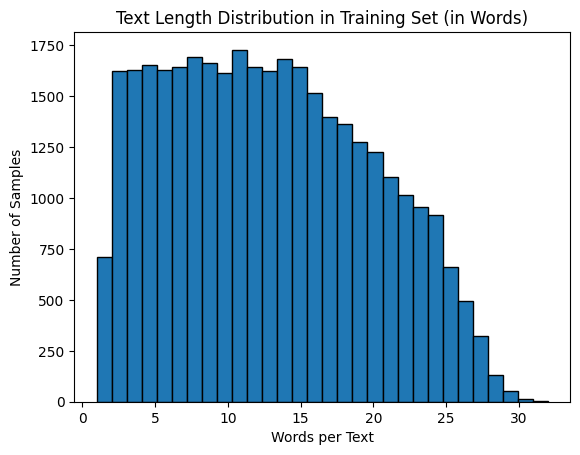

count    34638.000000
mean        12.984006
std          6.698078
min          1.000000
25%          7.000000
50%         13.000000
75%         18.000000
max         32.000000
Name: text, dtype: float64


In [ ]:
# Understaning the size of text inputs

# Calculate number of words per text
x_train_lengths = x_train.str.split().apply(len)

# Plot histogram of text lengths
x_train_lengths.plot(kind='hist', bins=30, edgecolor='black')
plt.title("Text Length Distribution in Training Set (in Words)")
plt.xlabel("Words per Text")
plt.ylabel("Number of Samples")
plt.show()

# Describe text length stats
print(x_train_lengths.describe())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

count    34638.000000
mean        19.350424
std          8.679747
min          3.000000
50%         19.000000
90%         31.000000
95%         34.000000
99%         38.000000
max        316.000000
Name: text, dtype: float64


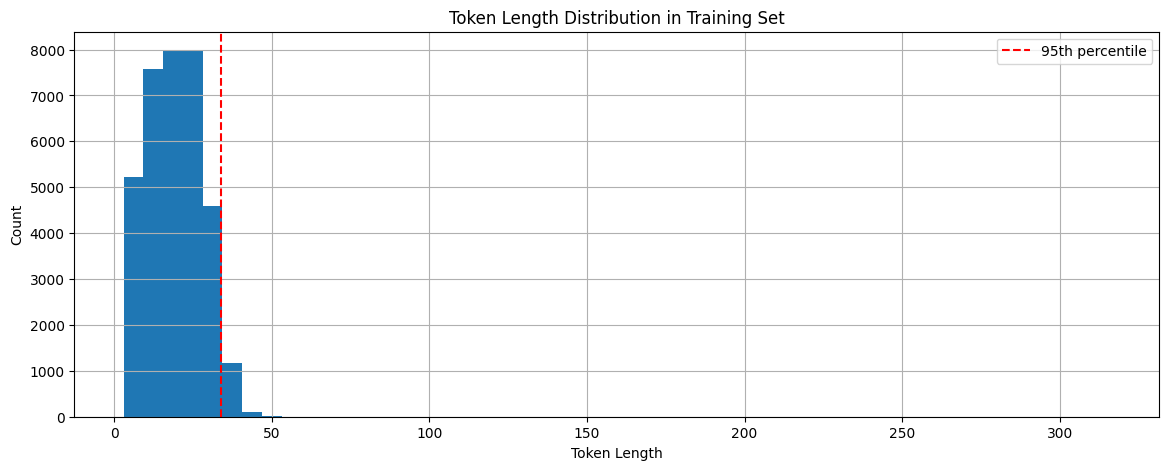

In [ ]:
# token length analysis - help to decide the max sequence length

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
token_lengths = x_train.apply(lambda x: len(tokenizer.encode(x, truncation=False)))

# summary statistics
print(token_lengths.describe(percentiles=[0.9, 0.95, 0.99]))

plt.figure(figsize=(14, 5))
token_lengths.hist(bins=50)
plt.axvline(token_lengths.quantile(0.95), color='red', linestyle='dashed', label='95th percentile')
plt.title("Token Length Distribution in Training Set")
plt.xlabel("Token Length")
plt.ylabel("Count")
plt.legend()
plt.show()

# Creating Baseline Model

Defining sequence length and truncate all records at that length. For records that are shorter than our defined sequence length will add padding characters to insure that input shapes are consistent across all records

In [ ]:
from torch.nn import BCEWithLogitsLoss
from transformers import PreTrainedModel

# compute label frequency
label_freq = y_train.sum() / len(y_train)

# compute pos_weight
pos_weight = (1.0 - label_freq) / label_freq
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32)

class Multi_Label_With_Weights(nn.Module):
    def __init__(self, base_model: PreTrainedModel, pos_weight: torch.Tensor):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        supported_keys = {"token_type_ids","position_ids","head_mask","inputs_embeds",
            "output_attentions","output_hidden_states","return_dict"}
        filtered_kwargs = {k: v for k, v in kwargs.items() if k in supported_keys}

        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **filtered_kwargs)
        logits = outputs.logits

        if labels is not None:
            loss = self.loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


In [ ]:
MAX_SEQUENCE_LENGTH = 35

In [ ]:
label_cols = emotions.columns.difference(['text','text_length'])  # Skip the 'text' and 'text_length' column

# Preprocessing function that accepts both data and tokenizer
def preprocess_emotions(data, tokenizer):
    """
    Function tokenizes text and converts the emotion labels into a list of floats
    """
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Process multi-label binary targets
    encoded["labels"] = [
        [float(data[label][i]) for label in label_cols]
        for i in range(len(data["text"]))
    ]

    return encoded

###########################################################################
# Compute Metric Baseline
def compute_metrics(p):
    predictions, labels = p
    predictions = (predictions > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    subset_accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='micro')
    recall = recall_score(labels, predictions, average='micro')
    f1 = f1_score(labels, predictions, average='micro')

    # Return all the metrics
    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


################################################################################
# Compute Metric Fine Tuned
def best_threshold_compute_metrics(p):
    global best_thresholds
    predictions, labels = p

    # Load the best thresholds if they exist
    try:
        best_thresholds = np.load("best_thresholds.npy")
    except FileNotFoundError:
        print("Best thresholds not found. Using default 0.5 thresholds.")
        best_thresholds = None

    # Apply sigmoid if not already applied
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    # Use optimized thresholds if available
    if best_thresholds is not None:
        binary_predictions = np.zeros_like(predictions)
        for i, thresh in enumerate(best_thresholds):
            binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
    else:
        binary_predictions = (predictions >= 0.5).astype(int)

    # Calculate metrics
    subset_accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions, average='micro')
    recall = recall_score(labels, binary_predictions, average='micro')
    f1 = f1_score(labels, binary_predictions, average='micro')

    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

###########################################################################

# Use a wrapper function to pass the tokenizer to the preprocess function
def preprocess_with_tokenizer(batch, tokenizer):
    return preprocess_emotions(batch, tokenizer)

###########################################################################

def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   training_arguments=None,
                                   batch_size=16,
                                   num_epochs=2,
                                   metrics= compute_metrics):
    """
    Preprocess the data using the given tokenizer.
    Create the training arguments and trainer for the given model and data.
    Then train it.
    """
    # Preprocess the data
    preprocessed_train_data = train_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Set the training arguments if not provided
    if training_arguments is None:
        training_args = TrainingArguments(
            output_dir="emotions_model",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_epochs,
            eval_strategy="epoch",
            save_strategy="epoch",
            report_to='none'
        )
    else:
        training_args = training_arguments

    # Set up the trainer
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        tokenizer=tokenizer,
        compute_metrics=metrics
    )

    # Train the model
    trainer.train()

    return trainer, preprocessed_dev_data

###########################################################################


def fine_tune_classif_model_freeze_layers(classification_model,
                                          tokenizer,
                                          train_data,
                                          dev_data,
                                          layers_to_train=["classifier."],
                                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                                          batch_size=16,
                                          num_epochs=2,
                                          metrics=compute_metrics):
    """
    Fine-tune a classification model while freezing all layers except those specified
    in layers_to_train (partial substring match on parameter names).
    """

    # Preprocess the datasets with the tokenizer
    preprocessed_train_data = train_data.map(
        preprocess_with_tokenizer,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )
    preprocessed_dev_data = dev_data.map(
        preprocess_with_tokenizer,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )

    # Freeze all layers except those matching substrings in layers_to_train
    for name, param in classification_model.named_parameters():
      if not any(layer_name in name for layer_name in layers_to_train):
        param.requires_grad = False

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="bert_fine_tuned_freeze_emotions",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to='none'
    )

    # Define Trainer
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        compute_metrics=metrics
    )
    # Train the model
    trainer.train()

    return trainer, preprocessed_dev_data

###########################################################################


def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df


In [ ]:
# Baseline Model - BERT

model_checkpoint_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint_name)

# Load BERT model
bert_model = BertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")
bert_withWeight_model = Multi_Label_With_Weights(base_model=bert_model, pos_weight=pos_weight_tensor)

trainer, preprocessed_val_data = fine_tune_classification_model(bert_withWeight_model, bert_tokenizer, train_dataset, val_dataset)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-14-2766648364.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.836600,0.810310,0.040880,0.394503,0.642838,0.488945
2,0.696500,0.798424,0.052746,0.401667,0.638915,0.493245


In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_val_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on validation data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on validation data:

Text: Call your legislator and complain. Ill-mannered public servants tend to fear politicians more than they do lawyers.
Predicted labels: ['anger', 'annoyance', 'caring', 'disapproval', 'disgust', 'fear', 'nervousness', 'neutral']
Actual labels:    ['caring', 'disgust', 'neutral']

Text: Facts no fiction
Predicted labels: ['disapproval', 'neutral']
Actual labels:    ['neutral']

Text: Hell yeah. Enjoy your new bachelor life son!
Predicted labels: ['admiration', 'amusement', 'caring', 'excitement', 'joy']
Actual labels:    ['excitement', 'joy']

Text: Yeah I was citing the wrong statistic here. Thanks for posting this.
Predicted labels: ['disapproval', 'gratitude', 'realization']
Actual labels:    ['disgust', 'gratitude']

Text: I do but no one wants to play with me I at least try to play by my self but it gets really boring.
Predicted labels: ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'nervousness', 'neutral'

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': bert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.7986478805541992, 'eval_subset_accuracy': 0.049974016975575956, 'eval_precision': 0.40397489938774345, 'eval_recall': 0.641002360631923, 'eval_f1': 0.49560669700834203, 'eval_runtime': 24.9183, 'eval_samples_per_second': 463.355, 'eval_steps_per_second': 28.975, 'epoch': 2.0}


# RoBERTa Model

In [ ]:
label_frequencies = emotions[label_cols].mean().values
class_weights = 1.0 / (label_frequencies + 1e-5)  # Add epsilon to avoid division by zero
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define the custom Roberta model
class RobertaForMultiLabelClassification(RobertaPreTrainedModel):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.class_weights = class_weights

        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Get outputs from the base model
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0, :])  # CLS token

        logits = self.classifier(pooled_output)

        # If labels are provided, calculate loss using BCE with logits
        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits, labels.float())

        return {'loss': loss, 'logits': logits}

In [ ]:
# Load Roberta model and tokenizer
model_checkpoint_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

# Initialize the custom model with class weights
roberta_finetune_model = RobertaForMultiLabelClassification.from_pretrained(
    model_checkpoint_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    class_weights=class_weights
)


# Fine-tune the model
trainer, preprocessed_val_data = fine_tune_classification_model(roberta_finetune_model,
                                                                roberta_tokenizer,
                                                                train_dataset,
                                                                val_dataset,
                                                                training_arguments = None ,
                                                                batch_size = 32,
                                                                num_epochs = 2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForMultiLabelClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34639 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-11-2766648364.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.395600,1.345755,0.006668,0.221987,0.898992,0.356054
2,1.211200,1.325952,0.010825,0.268245,0.874285,0.410532


In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_val_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on validation data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on validation data:

Text: Is that how you deal with people you disagree with? Nice personal fantasy you have there.
Predicted labels: ['admiration', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disapproval', 'excitement', 'gratitude', 'joy', 'love', 'neutral', 'optimism', 'pride', 'realization', 'surprise']
Actual labels:    ['admiration', 'confusion', 'curiosity', 'joy']

Text: If you crack the code for getting a city job please let me know.
Predicted labels: ['approval', 'caring', 'confusion', 'curiosity', 'desire', 'gratitude', 'neutral', 'optimism', 'realization']
Actual labels:    ['neutral']

Text: came here to say this. i've watched it through more than five times at this point. one of my absolute favorites.
Predicted labels: ['admiration', 'amusement', 'approval', 'desire', 'excitement', 'joy', 'love', 'neutral', 'optimism', 'pride', 'realization']
Actual labels:    ['admiration', 'approval', 'joy', 'love', 'neutral']

Text: I agree. Po

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 1.3182759284973145, 'eval_subset_accuracy': 0.012125411397886714, 'eval_precision': 0.2700845418543034, 'eval_recall': 0.875056875056875, 'eval_f1': 0.41276881912747354, 'eval_runtime': 22.9416, 'eval_samples_per_second': 503.278, 'eval_steps_per_second': 15.736, 'epoch': 2.0}


**Threshold:** Creating thresholds based on best F1 score

In [ ]:
def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df



predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
predictions = 1 / (1 + np.exp(-logits))

threshold_results_df = optimize_thresholds_verbose(predictions, true_labels, label_cols)

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 15.70it/s]


In [ ]:
threshold_results_df

,label,threshold,f1
admiration,admiration,0.90,0.667737
amusement,amusement,0.95,0.727855
anger,anger,0.90,0.528447
annoyance,annoyance,0.80,0.515203
approval,approval,0.80,0.486470
caring,caring,0.90,0.470703
confusion,confusion,0.90,0.534190
curiosity,curiosity,0.90,0.665468
desire,desire,0.95,0.420878
disappointment,disappointment,0.85,0.415604


In [ ]:
# trainer, preprocessed_val_data = fine_tune_classif_model_freeze_layers(
#     roberta_withWeight_model,
#     roberta_tokenizer,
#     train_dataset,
#     val_dataset,
#     layers_to_train=["classifier.", "encoder.layer.11"],
#     batch_size=32,
#     num_epochs=2
# )

# training model using the new thresholds
trainer, preprocessed_val_data = fine_tune_classification_model(roberta_finetune_model,
                                                                roberta_tokenizer,
                                                                train_dataset,
                                                                val_dataset,
                                                                training_arguments = None ,
                                                                batch_size = 32,
                                                                num_epochs = 2,
                                                                metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-11-1438559662.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.058800,1.525093,0.071627,0.497404,0.646821,0.562357
2,0.950900,1.490344,0.065650,0.473631,0.675069,0.556688


In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on validation data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on validation data:

Text: Call your legislator and complain. Ill-mannered public servants tend to fear politicians more than they do lawyers.
Predicted labels: ['anger', 'annoyance', 'fear', 'neutral']
Actual labels:    ['caring', 'disgust', 'neutral']

Text: Facts no fiction
Predicted labels: ['approval', 'disapproval', 'neutral']
Actual labels:    ['neutral']

Text: Hell yeah. Enjoy your new bachelor life son!
Predicted labels: ['excitement', 'joy']
Actual labels:    ['excitement', 'joy']

Text: Yeah I was citing the wrong statistic here. Thanks for posting this.
Predicted labels: ['approval', 'gratitude', 'realization']
Actual labels:    ['disgust', 'gratitude']

Text: I do but no one wants to play with me I at least try to play by my self but it gets really boring.
Predicted labels: ['annoyance', 'disappointment', 'disapproval', 'neutral', 'realization']
Actual labels:    ['approval', 'disappointment', 'disapproval', 'sadness']


In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 1.4856257438659668, 'eval_subset_accuracy': 0.06504417114152088, 'eval_precision': 0.4726963906581741, 'eval_recall': 0.6738090914593547, 'eval_f1': 0.5556137855306831, 'eval_runtime': 23.0524, 'eval_samples_per_second': 500.86, 'eval_steps_per_second': 15.66, 'epoch': 2.0}


In [ ]:
model_checkpoint_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

# Initialize the custom model with class weights
roberta_finetune_model = RobertaForMultiLabelClassification.from_pretrained(
    model_checkpoint_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    class_weights=class_weights
)

for name, param in roberta_finetune_model.named_parameters():
    if name.startswith("roberta.embeddings") or \
       name.startswith("roberta.encoder.layer.0") or \
       name.startswith("roberta.encoder.layer.1") or \
       name.startswith("roberta.encoder.layer.2"):
        param.requires_grad = False



trainer, preprocessed_val_data = fine_tune_classification_model(roberta_finetune_model,
                                                                roberta_tokenizer,
                                                                train_dataset,
                                                                val_dataset,
                                                                training_arguments = None ,
                                                                batch_size = 32,
                                                                num_epochs = 2,
                                                                metrics=best_threshold_compute_metrics)

Some weights of RobertaForMultiLabelClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34639 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-11-2766648364.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.407900,1.352664,0.049710,0.453107,0.632240,0.527891
2,1.263000,1.313670,0.064346,0.480410,0.642656,0.549813


In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on validation data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on validation data:

Text: Is that how you deal with people you disagree with? Nice personal fantasy you have there.
Predicted labels: ['annoyance', 'confusion', 'curiosity', 'neutral']
Actual labels:    ['admiration', 'confusion', 'curiosity', 'joy']

Text: If you crack the code for getting a city job please let me know.
Predicted labels: ['desire', 'neutral', 'optimism']
Actual labels:    ['neutral']

Text: came here to say this. i've watched it through more than five times at this point. one of my absolute favorites.
Predicted labels: ['admiration', 'approval', 'excitement', 'joy', 'love']
Actual labels:    ['admiration', 'approval', 'joy', 'love', 'neutral']

Text: I agree. Pockets especially on dresses just feel weird.
Predicted labels: ['annoyance', 'approval', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'neutral']
Actual labels:    ['amusement', 'annoyance', 'approval', 'disgust']

Text: Being pregnant and having two kids only made me more pro-abort

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 1.3108339309692383, 'eval_subset_accuracy': 0.06426468040879958, 'eval_precision': 0.4828564940962761, 'eval_recall': 0.6450389783723117, 'eval_f1': 0.5522874543872635, 'eval_runtime': 22.7999, 'eval_samples_per_second': 506.406, 'eval_steps_per_second': 15.833, 'epoch': 2.0}


# DeBERTa Model

In [ ]:
# Define label columns
label_cols = emotions.columns.difference(["text", "text_length"])

# Compute Class Weights
label_frequencies = emotions[label_cols].mean().values
class_weights = 1.0 / (label_frequencies + 1e-5)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
class DebertaWeightedTrainer(Trainer):
    def __init__(self, *args, pos_weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight
        if self.pos_weight is not None:
            self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        else:
            self.loss_fn = nn.BCEWithLogitsLoss()

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels.float())
        return (loss, outputs) if return_outputs else loss


In [ ]:
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
# DeBERTa checkpoint name
deberta_checkpoint = "microsoft/deberta-v3-base"

# Load tokenizer
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained(deberta_checkpoint)

# Load model for multi-label classification
deberta_model = DebertaV2ForSequenceClassification.from_pretrained(
    deberta_checkpoint,
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# First Fine-tuning Run

trainer, preprocessed_val_data = fine_tune_classification_model(
    deberta_model,
    deberta_tokenizer,
    train_dataset,
    val_dataset,
    num_epochs=2,
    batch_size=16
)


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

['text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'input_ids', 'attention_mask', 'labels']


/tmp/ipython-input-15-4176968364.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.212900,0.204128,0.142474,0.794270,0.311917,0.447928
2,0.193200,0.197150,0.147930,0.774883,0.361723,0.493211


In [ ]:
# Predict and inspect outputs for DeBERTa model
predictions_output = trainer.predict(preprocessed_val_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on validation data (DeBERTa model):")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")



Predictions on validation data (DeBERTa model):

Text: Call your legislator and complain. Ill-mannered public servants tend to fear politicians more than they do lawyers.
Predicted labels: ['neutral']
Actual labels:    ['caring', 'disgust', 'neutral']

Text: Facts no fiction
Predicted labels: ['disapproval', 'neutral']
Actual labels:    ['neutral']

Text: Hell yeah. Enjoy your new bachelor life son!
Predicted labels: ['excitement', 'joy']
Actual labels:    ['excitement', 'joy']

Text: Yeah I was citing the wrong statistic here. Thanks for posting this.
Predicted labels: ['gratitude']
Actual labels:    ['disgust', 'gratitude']

Text: I do but no one wants to play with me I at least try to play by my self but it gets really boring.
Predicted labels: ['disappointment', 'disapproval']
Actual labels:    ['approval', 'disappointment', 'disapproval', 'sadness']


In [ ]:
# Evaluate the Fine-Tuned Model
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

# Evaluate on test set
test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.1980050504207611, 'eval_subset_accuracy': 0.1461112073445349, 'eval_precision': 0.7708265165892284, 'eval_recall': 0.35648568488590276, 'eval_f1': 0.48751112306769034, 'eval_runtime': 37.188, 'eval_samples_per_second': 310.476, 'eval_steps_per_second': 19.415, 'epoch': 2.0}


In [ ]:
from tqdm import tqdm
def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}

    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)

        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df

In [ ]:
threshold_results_df = optimize_thresholds_verbose(probs, true_labels, label_cols.tolist())
threshold_results_df

Optimizing thresholds: 100%|██████████| 19/19 [00:04<00:00,  4.49it/s]


,label,threshold,f1
admiration,admiration,0.40,0.703539
amusement,amusement,0.55,0.758477
anger,anger,0.30,0.554568
annoyance,annoyance,0.20,0.514042
approval,approval,0.25,0.502758
caring,caring,0.20,0.475287
confusion,confusion,0.30,0.545918
curiosity,curiosity,0.30,0.688712
desire,desire,0.25,0.456522
disappointment,disappointment,0.25,0.438474


In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Apply thresholds
binary_predictions = np.zeros_like(probs)
for i, thresh in enumerate(best_thresholds):
    binary_predictions[:, i] = (probs[:, i] >= thresh).astype(int)


In [ ]:
# Recompute Metrics
subset_accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions, average='micro')
recall = recall_score(true_labels, binary_predictions, average='micro')
f1 = f1_score(true_labels, binary_predictions, average='micro')

print({
    "subset_accuracy": subset_accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

{'subset_accuracy': 0.08756279230902476, 'precision': 0.5245063994443894, 'recall': 0.6429896311612491, 'f1': 0.5777358851413193}


In [ ]:
# Preprocess the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

# Get predictions on the test set
predictions_output_test = trainer.predict(preprocessed_test_data)

# Convert logits → probabilities
logits_test = predictions_output_test.predictions
probs_test = 1 / (1 + np.exp(-logits_test))

# Apply thresholds
binary_predictions_test = np.zeros_like(probs_test)
for i, thresh in enumerate(best_thresholds):
    binary_predictions_test[:, i] = (probs_test[:, i] >= thresh).astype(int)

# True labels
true_labels_test = test_dataset.to_pandas()[label_cols.tolist()].values

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

In [ ]:
# Compute test metrics
subset_accuracy = accuracy_score(true_labels_test, binary_predictions_test)
precision = precision_score(true_labels_test, binary_predictions_test, average='micro')
recall = recall_score(true_labels_test, binary_predictions_test, average='micro')
f1 = f1_score(true_labels_test, binary_predictions_test, average='micro')

print("Test Set Metrics:")
print({
    "subset_accuracy": subset_accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

Test Set Metrics:
{'subset_accuracy': 0.08825567296033258, 'precision': 0.5193572129538764, 'recall': 0.6406694510017553, 'f1': 0.5736700902414569}


In [ ]:
#Inspect predictions on test data
texts = test_dataset["text"]

for i in range(5):
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if binary_predictions_test[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels_test[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")



Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'excitement', 'realization', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['caring', 'grief', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['approval', 'confusion', 'curiosity', 'neutral']
Actual lab

### Freeze Layers in DeBERTa

In [ ]:
# Freeze all layers except classifier in DeBERTa
for name, param in deberta_model.named_parameters():
    if not any(layer in name for layer in ["classifier", "pooler"]):
        param.requires_grad = False

In [ ]:
# Freeze embeddings and first 6 encoder layers
for name, param in deberta_model.named_parameters():
    if name.startswith("deberta.embeddings") or \
       name.startswith("deberta.encoder.layer.0") or \
       name.startswith("deberta.encoder.layer.1") or \
       name.startswith("deberta.encoder.layer.2") or \
       name.startswith("deberta.encoder.layer.3") or \
       name.startswith("deberta.encoder.layer.4") or \
       name.startswith("deberta.encoder.layer.5"):
        param.requires_grad = False

In [ ]:
# Re-run Training: freeze all except classifier
for name, param in deberta_model.named_parameters():
    if not any(layer in name for layer in ["classifier", "pooler"]):
        param.requires_grad = False

trainer, preprocessed_val_data = fine_tune_classification_model(
    deberta_model,
    deberta_tokenizer,
    train_dataset,
    val_dataset,
    num_epochs=2,
    batch_size=16
)


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

['text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'input_ids', 'attention_mask', 'labels']


/tmp/ipython-input-15-4176968364.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.172900,0.201117,0.148623,0.738293,0.405571,0.523541
2,0.179100,0.200495,0.149489,0.738789,0.400249,0.519210


In [ ]:
# Predict on validation data
predictions_output = trainer.predict(preprocessed_val_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Inspect a few samples
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

for i in range(5):
    print(f"\nText: {texts[i]}")
    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]
    print(f"Predicted: {predicted}")
    print(f"Actual: {actual}")



Text: Call your legislator and complain. Ill-mannered public servants tend to fear politicians more than they do lawyers.
Predicted: ['anger', 'fear', 'neutral']
Actual: ['caring', 'disgust', 'neutral']

Text: Facts no fiction
Predicted: ['disapproval', 'neutral']
Actual: ['neutral']

Text: Hell yeah. Enjoy your new bachelor life son!
Predicted: ['excitement', 'joy']
Actual: ['excitement', 'joy']

Text: Yeah I was citing the wrong statistic here. Thanks for posting this.
Predicted: ['gratitude']
Actual: ['disgust', 'gratitude']

Text: I do but no one wants to play with me I at least try to play by my self but it gets really boring.
Predicted: ['annoyance', 'disappointment', 'disapproval', 'sadness']
Actual: ['approval', 'disappointment', 'disapproval', 'sadness']


In [ ]:
# Preprocess test data
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.2014206498861313, 'eval_subset_accuracy': 0.14922917027542007, 'eval_precision': 0.7387580299785867, 'eval_recall': 0.3967677501361903, 'eval_f1': 0.5162636843348822, 'eval_runtime': 38.0068, 'eval_samples_per_second': 303.788, 'eval_steps_per_second': 18.997, 'epoch': 2.0}


In [ ]:
threshold_results_df = optimize_thresholds_verbose(probs, true_labels, label_cols)
threshold_results_df

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 14.35it/s]


,label,threshold,f1
admiration,admiration,0.45,0.704248
amusement,amusement,0.45,0.759816
anger,anger,0.30,0.546032
annoyance,annoyance,0.25,0.513222
approval,approval,0.20,0.506560
caring,caring,0.25,0.475985
confusion,confusion,0.30,0.548307
curiosity,curiosity,0.30,0.691293
desire,desire,0.30,0.468401
disappointment,disappointment,0.25,0.441035


In [ ]:
# Load thresholds
best_thresholds = threshold_results_df["threshold"].values

# Apply thresholds
binary_predictions = np.zeros_like(probs)
for i, thresh in enumerate(best_thresholds):
    binary_predictions[:, i] = (probs[:, i] >= thresh).astype(int)


In [ ]:
#Recompute metrics on validation set
subset_accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions, average='micro')
recall = recall_score(true_labels, binary_predictions, average='micro')
f1 = f1_score(true_labels, binary_predictions, average='micro')

print({
    "subset_accuracy": subset_accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

{'subset_accuracy': 0.08886194353022692, 'precision': 0.52599486521181, 'recall': 0.6478851825949463, 'f1': 0.5806117582941617}


In [ ]:
# Apply thresholds on the test set
# Preprocess test data
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': deberta_tokenizer}
)

# Predict on test data
test_predictions_output = trainer.predict(preprocessed_test_data)

# Convert logits to probabilities
test_logits = test_predictions_output.predictions
test_probs = 1 / (1 + np.exp(-test_logits))

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

In [ ]:
# apply saved thresholds:
binary_test_predictions = np.zeros_like(test_probs)
for i, thresh in enumerate(best_thresholds):
    binary_test_predictions[:, i] = (test_probs[:, i] >= thresh).astype(int)

true_test_labels = test_dataset.to_pandas()[label_cols.tolist()].values

# Compute test metrics:
subset_accuracy = accuracy_score(true_test_labels, binary_test_predictions)
precision = precision_score(true_test_labels, binary_test_predictions, average='micro')
recall = recall_score(true_test_labels, binary_test_predictions, average='micro')
f1 = f1_score(true_test_labels, binary_test_predictions, average='micro')

print({
    "subset_accuracy": subset_accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})


{'subset_accuracy': 0.08877533344881344, 'precision': 0.5208307880268784, 'recall': 0.6450880697294352, 'f1': 0.576338096718807}


# DistilBERT Model

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertPreTrainedModel


class DistilBERTWeightedClassification(DistilBertPreTrainedModel):
    def __init__(self, config, pos_weight=None):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config)
        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        if pos_weight is not None:
            self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            self.loss_fn = nn.BCEWithLogitsLoss()

        # Initialize the model weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0, :])

        logits = self.classifier(pooled_output)

        if labels is not None:
            loss = self.loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

In [ ]:
# calculate weights for the labels

label_freq = y_train.sum() / len(y_train)
pos_weight = (1.0 - label_freq) / label_freq
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32)

In [ ]:
# Baseline Model - DistilBERT

from transformers import DistilBertTokenizerFast

distilbert_checkpoint = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_checkpoint)


# Load DistilBERT model
distilbert_model = DistilBERTWeightedClassification.from_pretrained(
                                  distilbert_checkpoint,
                                  num_labels=len(label_cols),
                                  problem_type="multi_label_classification",
                                  pos_weight = pos_weight_tensor
                                  )


trainer, preprocessed_val_data= fine_tune_classification_model(
                                  classification_model=distilbert_model,
                                  tokenizer=distilbert_tokenizer,
                                  train_data=train_dataset,
                                  dev_data=val_dataset,
                                  batch_size=16,
                                  num_epochs=2
                                )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBERTWeightedClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fn.pos_weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-17-2766648364.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.829700,0.803564,0.045990,0.411432,0.637121,0.499988
2,0.698100,0.797511,0.057249,0.419200,0.638672,0.506169


In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_val_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on validation data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on validation data:

Text: Call your legislator and complain. Ill-mannered public servants tend to fear politicians more than they do lawyers.
Predicted labels: ['anger', 'caring', 'disapproval', 'fear', 'nervousness', 'neutral']
Actual labels:    ['caring', 'disgust', 'neutral']

Text: Facts no fiction
Predicted labels: ['disapproval', 'neutral']
Actual labels:    ['neutral']

Text: Hell yeah. Enjoy your new bachelor life son!
Predicted labels: ['admiration', 'amusement', 'caring', 'excitement', 'gratitude', 'joy', 'love', 'optimism']
Actual labels:    ['excitement', 'joy']

Text: Yeah I was citing the wrong statistic here. Thanks for posting this.
Predicted labels: ['disapproval', 'gratitude', 'realization']
Actual labels:    ['disgust', 'gratitude']

Text: I do but no one wants to play with me I at least try to play by my self but it gets really boring.
Predicted labels: ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'nervousness', 

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.8028601408004761, 'eval_subset_accuracy': 0.05603672267451931, 'eval_precision': 0.4149744439839757, 'eval_recall': 0.6364021548332426, 'eval_f1': 0.5023711401779848, 'eval_runtime': 12.8067, 'eval_samples_per_second': 901.559, 'eval_steps_per_second': 56.377, 'epoch': 2.0}


In [ ]:
threshold_results_df = optimize_thresholds_verbose(probs, true_labels, label_cols)

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00,  9.85it/s]


In [ ]:
threshold_results_df

,label,threshold,f1
admiration,admiration,0.75,0.676708
amusement,amusement,0.90,0.763006
anger,anger,0.75,0.543697
annoyance,annoyance,0.60,0.499513
approval,approval,0.50,0.494070
caring,caring,0.80,0.464063
confusion,confusion,0.75,0.525502
curiosity,curiosity,0.75,0.681360
desire,desire,0.85,0.456747
disappointment,disappointment,0.65,0.443743


In [ ]:
trainer, preprocessed_val_data= fine_tune_classification_model(
                                  classification_model=distilbert_model,
                                  tokenizer=distilbert_tokenizer,
                                  train_data=train_dataset,
                                  dev_data=val_dataset,
                                  batch_size=16,
                                  num_epochs=2,
                                  metrics = best_threshold_compute_metrics
                                )

Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-40-2766648364.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.601700,0.881292,0.076303,0.506516,0.641713,0.566155
2,0.515400,0.925543,0.075611,0.499420,0.654848,0.566670


In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on validation data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on validation data:

Text: Call your legislator and complain. Ill-mannered public servants tend to fear politicians more than they do lawyers.
Predicted labels: ['disapproval', 'fear', 'nervousness', 'neutral']
Actual labels:    ['caring', 'disgust', 'neutral']

Text: Facts no fiction
Predicted labels: ['disapproval', 'neutral']
Actual labels:    ['neutral']

Text: Hell yeah. Enjoy your new bachelor life son!
Predicted labels: ['approval', 'caring', 'excitement', 'joy']
Actual labels:    ['excitement', 'joy']

Text: Yeah I was citing the wrong statistic here. Thanks for posting this.
Predicted labels: ['annoyance', 'disapproval', 'gratitude', 'realization']
Actual labels:    ['disgust', 'gratitude']

Text: I do but no one wants to play with me I at least try to play by my self but it gets really boring.
Predicted labels: ['annoyance', 'disappointment', 'disapproval', 'sadness']
Actual labels:    ['approval', 'disappointment', 'disapproval', 'sadness']


In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.9289194941520691, 'eval_subset_accuracy': 0.07223280789883943, 'eval_precision': 0.4937184777624943, 'eval_recall': 0.651776526844622, 'eval_f1': 0.5618428947848999, 'eval_runtime': 14.4105, 'eval_samples_per_second': 801.222, 'eval_steps_per_second': 50.102, 'epoch': 2.0}


### Unfreeze DistilBERT Model Layers

In [ ]:
for name, param in distilbert_model.named_parameters():
    print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

In [ ]:
"""
Show the output from training a DistilBERT classification model, when unfreezing
all layers except those specified in layers_to_train (partial substring match
on parameter names).

"""

distilbert_checkpoint = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_checkpoint)

distilbert_model_unfreezed = DistilBERTWeightedClassification.from_pretrained(
                                  distilbert_checkpoint,
                                  num_labels=len(label_cols),
                                  problem_type="multi_label_classification",
                                  pos_weight = pos_weight_tensor
                                )

layers_to_train = ["layer.3.attention.out_lin","layer.3.sa_layer_norm", "layer.3.ffn.lin2", "layer.3.ffn.lin1","layer.3.output_layer", "layer.4.output_layer", "layer.4.attention.out_lin","layer.4.sa_layer_norm", "layer.4.ffn.lin2", "layer.4.ffn.lin1", "layer.5."]


trainer, preprocessed_val_data= fine_tune_classif_model_freeze_layers(
                                  classification_model=distilbert_model_unfreezed,
                                  tokenizer=distilbert_tokenizer,
                                  train_data=train_dataset,
                                  dev_data=val_dataset,
                                  layers_to_train=layers_to_train,
                                  batch_size=16,
                                  num_epochs=2,
                                  metrics = best_threshold_compute_metrics
                                )

Some weights of DistilBERTWeightedClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fn.pos_weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.854200,0.825106,0.058722,0.495997,0.617904,0.550280
2,0.788800,0.804941,0.072493,0.509156,0.627330,0.562099


In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_val_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = val_dataset["text"]
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on validation data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on validation data:

Text: Call your legislator and complain. Ill-mannered public servants tend to fear politicians more than they do lawyers.
Predicted labels: ['anger', 'annoyance', 'caring', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'nervousness', 'neutral', 'sadness']
Actual labels:    ['caring', 'disgust', 'neutral']

Text: Facts no fiction
Predicted labels: ['disapproval', 'neutral']
Actual labels:    ['neutral']

Text: Hell yeah. Enjoy your new bachelor life son!
Predicted labels: ['admiration', 'amusement', 'caring', 'excitement', 'gratitude', 'joy', 'love', 'optimism']
Actual labels:    ['excitement', 'joy']

Text: Yeah I was citing the wrong statistic here. Thanks for posting this.
Predicted labels: ['annoyance', 'disappointment', 'disapproval', 'gratitude', 'realization']
Actual labels:    ['disgust', 'gratitude']

Text: I do but no one wants to play with me I at least try to play by my self but it gets really boring.
Predicted labels

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.8100965619087219, 'eval_subset_accuracy': 0.06850857439805993, 'eval_precision': 0.5035871156661786, 'eval_recall': 0.6245687307063738, 'eval_f1': 0.5575909864634838, 'eval_runtime': 12.7461, 'eval_samples_per_second': 905.848, 'eval_steps_per_second': 56.645, 'epoch': 2.0}
